50000


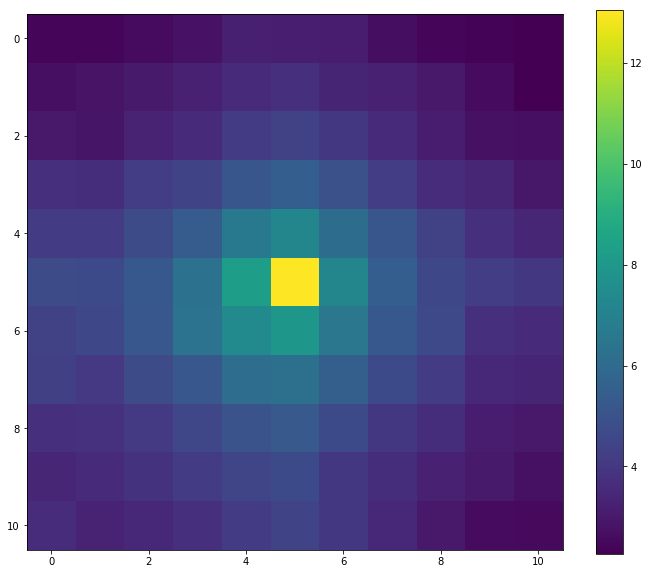

'\n#the chromosome for straw\nchromosome = "2"\n\n#these are the locations which will be fed into straw\nloc11 = 7005000\nloc12 = 7065000\nloc21 = 7150000\nloc22 = 7210000\n\n#this is the resolution that the data will be extracted with using straw\nres = 5000\nresolution = str(res)\n\n#Set this to true if you are looking at a point on the diagonal.\n#This mirrors the results from straw to create a symmetrical map.\nmirror = False\n\n\nlocation1 = ":".join([chromosome,str(loc11),str(loc12)])\nlocation2 = ":".join([chromosome,str(loc21),str(loc22)])\n\n#! echo /hdisk3/jordan/Downloads/straw/bin/Linux/straw KR $hic_file $location1 $location2 BP $resolution\n\n#call straw and put the results in to results\nresults = ! /hdisk3/jordan/Downloads/straw/bin/Linux/straw KR $hic_file $location1 $location2 BP $resolution\n#Here I am using the command-line straw program. You could instead import the straw module \n#and call the python method if you\'d prefer.\n\n#these are the bounds of the hic dat

In [4]:
#This first cell just loads in an example matrix representing the average interaction frequencies for a set of chromatin loops.
#But any square matrix can be used for the subsequent cells.

import matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['figure.figsize'] = (12,10)

#this should be the path to the local .hic file
hic_file = "/Zulu/xiaowen/HiC-Pro/hicfiles/DE.rep2rep3_allValidPairs.shuf522269193.hic"

loop_file = open("/Zulu/xiaowen/SIP_HIC/metaplot/H9_Diff_Cells/anchors/H9_vs_DE.UP.txt",'r')

chroms = []
location11s = []
location12s = []
location21s = []
location22s = []

res = 10000
resolution = str(res)

size = 11
halfsize = (size//2)*res

for line in loop_file:
    li = line.split()
    chroms.append(li[0])
    location11s.append(int(li[1])-halfsize)
    location12s.append(int(li[2])+halfsize-res)
    location21s.append(int(li[4])-halfsize)
    location22s.append(int(li[5])+halfsize-res)
    
    
mirror = False


#This will be the matrix we will load the hic data in to.
spots = np.zeros((len(chroms),size,size))

count = 0

for chrom,loc11,loc12,loc21,loc22 in zip(chroms,location11s,location12s,location21s,location22s):
    location1 = ":".join([chrom,str(loc11),str(loc12)])
    location2 = ":".join([chrom,str(loc21),str(loc22)])
    
    results = ! /hdisk3/jordan/Downloads/straw/bin/Linux/straw NONE $hic_file $location1 $location2 BP $resolution
    for result in results:
        re = result.split()
        left = (int(re[0])-loc11)//res
        right = (int(re[1])-loc21)//res
        score = float(re[2])
        spots[count,left,right] += score
        if mirror:
            spot[count,right,left] += score
            
    count += 1
   


mat = np.mean(spots,axis=0) 

plt.imshow(mat)
plt.colorbar()
plt.show()

spot = mat

In [6]:
#A quick method I stole from Stack Overflow for finding the nearest number in a sorted list

from bisect import bisect_left

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 0
    if pos == len(myList):
        return -1
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return pos
    else:
       return pos - 1

In [7]:
import math

#These are the parameters for the Bullseye Plot.

#the matrix you want to use, here we are using the matrix from the straw output above,
#but we feel free to replace this with any 2D numpy matrix.
mat = spot

#this is the size of the starting matrix
matsize = len(mat)

#this is the number of rings in the plot which corresponds to the Manhattan distance
rings = math.floor(math.sqrt(((matsize//2)**2)/2))

#This is the maximum number of rings that will be needed if square is set to True.
maxrings = math.ceil(math.sqrt(rings**2 + rings**2))

#this is the number of radial slices the circle is divided in to. Too few and the segments will be distorted.
slices = 2000

#this toggles on z-score normalization of each ring.
znorm = False

#this toggles between "closest-angle" mapping and "uniform segment length" mapping
uniform = True

#toggles comparison between square and circle
comparison = True

#this makes a square plot by trimming the edges of the plot. 
square = False

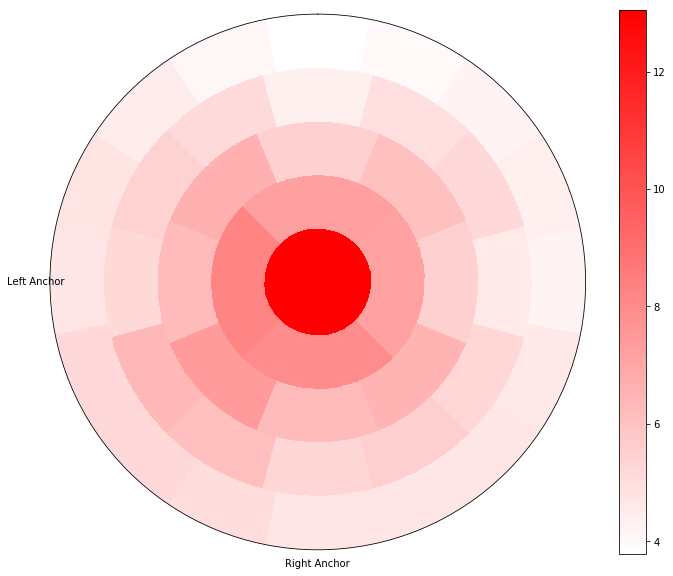

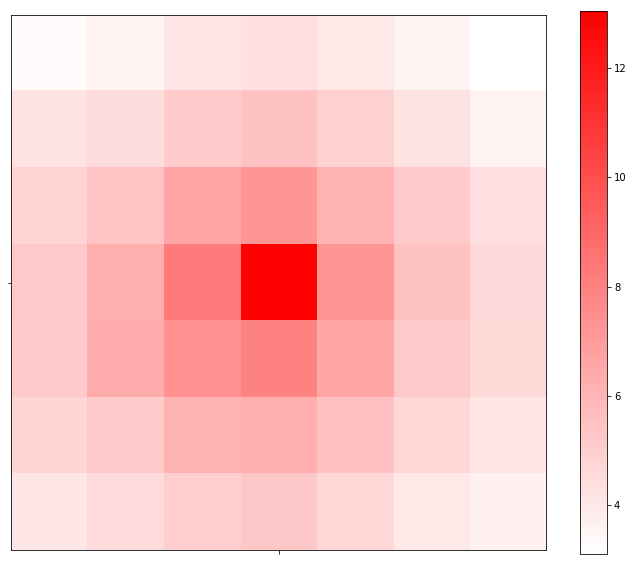

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import zscore
from matplotlib.colors import LinearSegmentedColormap


#First we compute the Manhattan distance and arctan of every point in the starting matrix
arctan = np.zeros((matsize,matsize))
manhattandistance = np.zeros((matsize,matsize))
for i in range(0,len(manhattandistance)):
    for j in range(0,len(manhattandistance)):
        manhattandistance[i,j] = abs(j-int((matsize-1)/2)) + abs(i-((matsize-1)/2))
        arctan[i,j] = np.arctan2(((j-int((matsize-1)/2))),((i-((matsize-1)/2))))
        
#We rearrange the Manhattan distances and arctans into lists based on the Manhattan distances.
#This means each ring is now represented by a list of scores and arctans.
manhat_arctans = []
manhat_scores = []
for a in range(matsize):
    manhat_arctans.append([])
    manhat_scores.append([])
    for b in range(matsize):
        for c in range(matsize):
            if (manhattandistance[b,c] == a):
                manhat_scores[a].append(mat[b,c])
                manhat_arctans[a].append(arctan[b,c])
                


#Next we construct the meshgrid for the circular plot.
rad = np.linspace(0, maxrings, maxrings+1)
azm = np.linspace(0, 2 * np.pi, slices)
r, th = np.meshgrid(rad, azm)

#now we trim the edges of the meshgrid to make a square
if square:
    for i in range(slices):
        for j in range(maxrings+1):
            #compute the cartesian coordinates of each quad to see if they need trimming
            nrad = r[i,j]
            theta = th[i,j]
            cosine = math.cos(theta)
            x = nrad * cosine
            sine = math.sin(theta)
            y = nrad * sine
            if abs(x) > abs(y):
                if abs(x) > rings:
                    nrad = abs(rings/cosine)
            else:
                if abs(y) > rings:
                    nrad = abs(rings/sine)
            r[i,j] = nrad

#This will be the new matrix that will be plotted. We need to fill it with the appropriate values.
C = np.zeros([slices,maxrings+1])

#For each ring we convert the arctans into thetas by making them all positive
#and adjusting for the slices.
for ring in range(maxrings):
    arctans = manhat_arctans[ring]
    thetas = [(x + np.pi) * ((slices/2)/np.pi) for x in arctans]
    scores = manhat_scores[ring]
    #Z-score normalization toggled by boolean value above.
    if znorm:
        if ring:
            scores = zscore(scores).tolist()
        else:
            scores = [0]
    #In order for the values to appropriately wrap around to 0 we need to add the last score to the beginning.
    thetas.append(0)
    scores.append(scores[0])
    #Here we sort the scores and thetas by the theta in order to help finding the closest one.
    sorted_scores = [x for _,x in sorted(zip(thetas,scores))]
    sorted_thetas = sorted(thetas)
    #Here to produce a uniform map we map the actual angles to idealized angles.
    if uniform:
        if ring:
            slices_per_segment = slices/(len(scores)-1)
            for t in range(len(sorted_thetas)):
                sorted_thetas[t] = slices_per_segment * t
                
    
    #Now for each slice in the ring we find the score corresponding to the nearest theta
    #and assign it to the appropriate coordinate in our matrix to be plotted: C.
    for i in range(slices):
        idx = takeClosest(sorted_thetas,i)
        C[i,ring] = sorted_scores[idx]
        
#create a juicebox-like red to white colormap
br = LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)])
        
ax = plt.subplot(projection="polar")

if znorm:
    plt.pcolormesh(th,r,C,cmap="seismic",vmin=-4,vmax=4)
else: 
    plt.pcolormesh(th,r,C,cmap=br,)#vmax=500,vmin=10)
if square:
    ax.axis('off')
else:
    ax.set_xticklabels(["","","Left Anchor","","Right Anchor","","",""])
    ax.set_yticklabels([])
    plt.colorbar()
    
#Rotate the plot so that the anchors go back to their original positions.
ax.set_theta_offset(np.pi/2)
#plt.title("Chr{0} vs Chr{1} at {2} BP Resolution".format(location1,location2,resolution))
plt.show()

if comparison:
    center = (matsize-1)//2
    left = center-rings
    right = center+rings+1
    plt.imshow(mat[left:right,left:right],cmap=br,)#vmax = 500,vmin = 10)
    #plt.title("Chr{0} vs Chr{1} at {2} BP Resolution".format(location1,location2,resolution))
    plt.xticks([center-left],labels=[])
    plt.yticks([center-left],labels=[])
    plt.colorbar()
    plt.show()
